<h1 align="center">Experimental Preprocessing Pipeline</h1>

<h2>Importing all Packages</h2>

In [1]:
import numpy as np
import random
import numpy as np
import tqdm
import json
import matplotlib.pyplot as plt
import h5py
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin #for GridSearchCv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Converting Files

In [ ]:
class ConvertingFiles():
    """
    Parameters:
    None
    
    Return
    (event_data, event_lengths) (packed np.arrays): data converted into .npy format
    """
    
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        file_h5py = h5py.File(X)
        keys_ls = list(file_h5py.keys())[0]
        keys = file_h5py[keys_ls]
        
        length_run = len(keys)
        event_lengths = np.zeros(length_run,int)
        
        event_data = np.full((length_run,np.max(event_lengths),4),np.nan)
        
        for i,e in enumerate(keys):
            event_lengths[i] = len(keys[e])
            
        for idx, key in tqdm.tqdm(enumerate(keys), desc="Stripping Point Clouds of ID information"):
            event_data[i] = keys[e]
            
        assert all(len(event_data[i]) == np.max(event_lengths) for i in range(len(event_data))), "Array length does not match number of events"
        
        return (event_data,event_lengths)

<h2>Outlier Detection</h2>

In [ ]:
class OutlierDetection:
    """
    Parameters
    None

    Return
    (event_data,new_event_lengths) (packed np.arrays): outliers removed packed data

    """
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        data,event_lengths = X
        event_data = np.full(data.shape, np.nan)
        new_event_lengths = np.full_like(event_lengths, np.nan)
        tot_count = 0

        for i in range(len(data)):
            event_points = data[i,:]
            condition = ((-270 <= event_points[:, 0]) & (event_points[:, 0] <= 270) &   
                (-270 <= event_points[:, 1]) & (event_points[:, 1] <= 270) &
                (0 <= event_points[:, 2]) & (event_points[:, 2]  <= 1003))
            allowed_points = event_points[condition] #only allows points that are not outliers

            event_data[i,:len(allowed_points)] = allowed_points #only assigns the valid points to the new array

            new_event_lengths[i] = len(allowed_points)  #original event number minus the number of outliers
            tot_count+=event_lengths[i] - new_event_lengths[i]

        print(f"Number of outlier points removed: {tot_count}") 
        return (event_data,new_event_lengths)

<h2>Up/Down Scaling</h2>

In [ ]:
class UpDownScaling(BaseEstimator,TransformerMixin):
    """
    Parameters
    target_size (int): which is the number of point I want to up/doen sample to 

    Return
    new_data (np.array): up/down sampled data with shape (run_events, target_size,4) 

    """
    def __init__(self,target_size,isotope,dimension=4):
        self.target_size = target_size
        self.pcloud_zeros = 0 #count if there are zero points in an event
        self.dimension = dimension 
        self.isotope = isotope

    def fit(self,X,y=None):
        return self 

    def transform(self,X,y=None): #for up/down scaling
        data,event_lengths = X #with shape (file,event_lenghts) X needs to be the only input to preserve the conventions of custom transformer
        len_run = len(data)
        # new_array_name = isotope + '_size' + str(sample_size) + '_sampled'
        new_data = np.full((len_run, self.target_size, self.dimension), np.nan) 

        for i in tqdm.tqdm(range(len_run),desc="Up/Downscaling in progress"): #
            ev_len = event_lengths[i] #length of event-- i.e. number of instances
            if ev_len == 0: #if event length is 0
                print(f"This event has 0 length: {i}")
                self.pcloud_zeros+=1
                continue
            if ev_len > self.target_size: #upsample
                random_points = np.random.choice(ev_len, self.target_size, replace=False)  #choosing the random instances to sample
                for r in range(len(random_points)):  # #only adds random sample_size points 
                    new_data[i,r] = data[i,random_points[r]]

            else:
                new_data[i,:ev_len,:] = data[i,:ev_len,:] #downsample
                need = self.target_size - ev_len
                random_points = np.random.choice(ev_len, need, replace= True if need > ev_len else False) #only repeats points more points needed than event length 
                count = ev_len
                for r in random_points:
                    new_data[i,count] = data[i,r]
                    if np.isnan(new_data[i, count, 0]):
                        print(f"NaN found at event {i}, index {count}") #need to make sure no nans remain
                    count += 1


        
        
        assert self.pcloud_zeros ==0, "There are events with no points"
        assert new_data.shape == (len_run, self.target_size, self.dimension), 'Array has incorrect shape'
        assert not np.isnan(new_data).any(), "NaNs detected in new_data" #very imporant to make sure there are no nans 
        
        print(f"Resampled shape of data: {new_data.shape}")
        return new_data

<h2>Scaling</h2>

In [ ]:
class ScalingData(BaseEstimator,TransformerMixin):
    """
    Parameters
    None

    Return
    X (np.array): MinMaxScaler() applied data for all columns

    """
    def __init__(self,dimension=4):
        self.dimension = dimension
        self.scaler = MinMaxScaler(feature_range=(-1, 1))

    def fit(self,X,y=None):
        return self 
    
    def transform(self,X,y=None):
        n_dict = {0:"x",1:"y",2:"z",3:"charge"}
        for n in range(self.dimension):
            data = X[:, :, n].reshape(-1, 1) #need to flatted the 2-D array first new shape (num_events*target_size)
            X[:, :, n] = self.scaler.fit_transform(data).reshape(X.shape[0], X.shape[1])
            print(f"Scaler min and max for feature {n_dict[n]}: {self.scaler.data_min_[0]}, {self.scaler.data_max_[0]}")

        return X

<h2>Forming the pipeline</h2>

In [ ]:
target_size = 800
isotope = "16O"
pipeline_1 = Pipeline([
    ("conversion", ConvertingFiles()),
    ("outlier",OutlierDetection()), #getting rid of the outliers
    ("sampler", UpDownScaling(target_size,isotope)),
]) #up/down sampler 

# The `pipeline_2` is a data processing pipeline that consists of the following steps:
pipeline_2 = Pipeline([
    ("scaling", ScalingData()),
]) #scaling (w/ concatonated dataset)

run_num = 104 #to look at individual runs


print(f"Pipeline for Run {run_num}")
file_path = ""

data_static = pipeline_1.fit_transform(file_path)


Pipeline for Run 10
Number of events skipped: 4


/mnt/home/singhp19/.conda/envs/tf_Jul2025/lib/python3.10/site-packages/numpy/_core/numeric.py:442: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


Number of outlier points removed: 0


100%|██████████| 9536/9536 [00:06<00:00, 1501.79it/s]


Transformed shape of data: (9536, 802, 4)
Pipeline for Run 11
Number of events skipped: 14
Number of outlier points removed: 0


100%|██████████| 9551/9551 [00:06<00:00, 1558.81it/s]


Transformed shape of data: (9551, 802, 4)
Pipeline for Run 12
Number of events skipped: 7
Number of outlier points removed: 0


100%|██████████| 9552/9552 [00:06<00:00, 1523.83it/s]


Transformed shape of data: (9552, 802, 4)
Pipeline for Run 13
Number of events skipped: 4
Number of outlier points removed: 0


100%|██████████| 9563/9563 [00:06<00:00, 1551.61it/s]


Transformed shape of data: (9563, 802, 4)
Pipeline for Run 14
Number of events skipped: 6
Number of outlier points removed: 0


100%|██████████| 9590/9590 [00:06<00:00, 1545.99it/s]


Transformed shape of data: (9590, 802, 4)
Pipeline for Run 15
Number of events skipped: 2
Number of outlier points removed: 0


100%|██████████| 9544/9544 [00:06<00:00, 1543.53it/s]


Transformed shape of data: (9544, 802, 4)
Pipeline for Run 16
Number of events skipped: 1
Number of outlier points removed: 0


100%|██████████| 9539/9539 [00:06<00:00, 1546.22it/s]


Transformed shape of data: (9539, 802, 4)
Pipeline for Run 17
Number of events skipped: 2
Number of outlier points removed: 0


100%|██████████| 9515/9515 [00:06<00:00, 1539.21it/s]


Transformed shape of data: (9515, 802, 4)
Pipeline for Run 18
Number of events skipped: 3
Number of outlier points removed: 0


100%|██████████| 9531/9531 [00:06<00:00, 1537.69it/s]


Transformed shape of data: (9531, 802, 4)
Pipeline for Run 19
Number of events skipped: 3
Number of outlier points removed: 0


100%|██████████| 9562/9562 [00:06<00:00, 1501.20it/s]


Transformed shape of data: (9562, 802, 4)
Pipeline for Run 20
Number of events skipped: 7
Number of outlier points removed: 0


100%|██████████| 9542/9542 [00:06<00:00, 1513.37it/s]


Transformed shape of data: (9542, 802, 4)
Pipeline for Run 21
Number of events skipped: 7
Number of outlier points removed: 0


100%|██████████| 9552/9552 [00:06<00:00, 1518.59it/s]


Transformed shape of data: (9552, 802, 4)
Pipeline for Run 22
Number of events skipped: 2
Number of outlier points removed: 0


100%|██████████| 9549/9549 [00:06<00:00, 1537.25it/s]


Transformed shape of data: (9549, 802, 4)
Pipeline for Run 23
Number of events skipped: 10
Number of outlier points removed: 0


100%|██████████| 9577/9577 [00:06<00:00, 1526.24it/s]


Transformed shape of data: (9577, 802, 4)
Pipeline for Run 24
Number of events skipped: 2
Number of outlier points removed: 0


100%|██████████| 9561/9561 [00:06<00:00, 1547.68it/s]


Transformed shape of data: (9561, 802, 4)
Pipeline for Run 25
Number of events skipped: 10
Number of outlier points removed: 0


100%|██████████| 9525/9525 [00:06<00:00, 1532.06it/s]


Transformed shape of data: (9525, 802, 4)
Pipeline for Run 26
Number of events skipped: 8
Number of outlier points removed: 0


100%|██████████| 9572/9572 [00:06<00:00, 1541.95it/s]


Transformed shape of data: (9572, 802, 4)
Pipeline for Run 27
Number of events skipped: 9
Number of outlier points removed: 0


100%|██████████| 9538/9538 [00:06<00:00, 1519.03it/s]


Transformed shape of data: (9538, 802, 4)
Pipeline for Run 28
Number of events skipped: 2
Number of outlier points removed: 0


100%|██████████| 9540/9540 [00:06<00:00, 1538.73it/s]


Transformed shape of data: (9540, 802, 4)
Pipeline for Run 29
Number of events skipped: 7
Number of outlier points removed: 1


100%|██████████| 9546/9546 [00:06<00:00, 1510.16it/s]


Transformed shape of data: (9546, 802, 4)
Pipeline for Run 30
Number of events skipped: 2
Number of outlier points removed: 0


100%|██████████| 9554/9554 [00:06<00:00, 1452.56it/s]


Transformed shape of data: (9554, 802, 4)
Pipeline for Run 31
Number of events skipped: 2
Number of outlier points removed: 0


100%|██████████| 9568/9568 [00:06<00:00, 1540.86it/s]


Transformed shape of data: (9568, 802, 4)
Pipeline for Run 32
Number of events skipped: 5
Number of outlier points removed: 0


100%|██████████| 9540/9540 [00:06<00:00, 1528.98it/s]


Transformed shape of data: (9540, 802, 4)
Pipeline for Run 33
Number of events skipped: 3
Number of outlier points removed: 0


100%|██████████| 9564/9564 [00:06<00:00, 1529.05it/s]


Transformed shape of data: (9564, 802, 4)
Pipeline for Run 34
Number of events skipped: 1
Number of outlier points removed: 0


100%|██████████| 9558/9558 [00:06<00:00, 1535.29it/s]


Transformed shape of data: (9558, 802, 4)
Pipeline for Run 35
Number of events skipped: 8
Number of outlier points removed: 0


100%|██████████| 9544/9544 [00:06<00:00, 1533.76it/s]


Transformed shape of data: (9544, 802, 4)
Pipeline for Run 36
Number of events skipped: 4
Number of outlier points removed: 0


100%|██████████| 9554/9554 [00:06<00:00, 1505.76it/s]


Transformed shape of data: (9554, 802, 4)
Pipeline for Run 37
Number of events skipped: 14
Number of outlier points removed: 0


100%|██████████| 9541/9541 [00:06<00:00, 1529.45it/s]


Transformed shape of data: (9541, 802, 4)
Pipeline for Run 38
Number of events skipped: 10
Number of outlier points removed: 0


100%|██████████| 9569/9569 [00:06<00:00, 1541.56it/s]


Transformed shape of data: (9569, 802, 4)
Pipeline for Run 39
Number of events skipped: 5
Number of outlier points removed: 0


100%|██████████| 9450/9450 [00:06<00:00, 1534.15it/s]


Transformed shape of data: (9450, 802, 4)
Pipeline for Run 40
Number of events skipped: 5
Number of outlier points removed: 0


100%|██████████| 9542/9542 [00:06<00:00, 1417.09it/s]


Transformed shape of data: (9542, 802, 4)
Pipeline for Run 41
Number of events skipped: 11
Number of outlier points removed: 0


100%|██████████| 9570/9570 [00:06<00:00, 1506.99it/s]


Transformed shape of data: (9570, 802, 4)
Pipeline for Run 42
Number of events skipped: 3
Number of outlier points removed: 0


100%|██████████| 9518/9518 [00:06<00:00, 1528.99it/s]


Transformed shape of data: (9518, 802, 4)
Pipeline for Run 43
Number of events skipped: 2
Number of outlier points removed: 0


100%|██████████| 9576/9576 [00:06<00:00, 1517.36it/s]


Transformed shape of data: (9576, 802, 4)
Pipeline for Run 44
Number of events skipped: 5
Number of outlier points removed: 0


100%|██████████| 9484/9484 [00:06<00:00, 1501.37it/s]


Transformed shape of data: (9484, 802, 4)


In [ ]:
transformed_data = pipeline_2.fit_transform(data_static)
print()
print(f"The full transformed data shape: {transformed_data.shape}")


Current class distribution is [ 13848 160739   9381  24316 125307]
The new shape after limiting to lowest class(46905, 802, 4)
Updated class distribution is [9381 9381 9381 9381 9381]
Scaler min and max for feature x: -269.95294, 269.95294
Scaler min and max for feature y: -267.79135, 267.79135
Scaler min and max for feature z: 0.0, 1002.597601610169
Scaler min and max for feature charge: 0.0, 4095.0

The full transformed data shape: (46905, 802, 4)


<h2>Visualizaing the point cloud</h2>

Label for the event 15 is 2.0


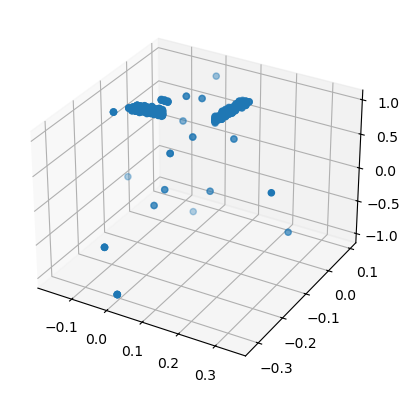

In [21]:
index = 15
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformed_data[index,:-2,0], transformed_data[index,:-2,1], transformed_data[index,:-2,2])
print(f"Label for the event {index} is {transformed_data[index,-2,0]}")


<h2>Outlier Omission Confirmation</h2>

In [13]:
mask = np.any((transformed_data[:, :-2, :3] > 1) | (transformed_data[:, :-2, :3] < -1), axis=(1, 2))
indices = np.argwhere(mask)
print(indices)
assert len(indices) == 0, "Points remain that are not within range[-1,1]"

[]


<h2>Saving to .npy files</h2>

In [ ]:
np.save('/mnt/research/attpc/e20020/Pointet_MLclassification/engine_training_data/' + isotope + '_size' + str(target_size)+'_test_features', X_test) #FILE CHANGE

